<a href="https://colab.research.google.com/github/SLVmain/ITMO_DL_in_practice_01/blob/main/f_2_2_YOLO5S_Training_small_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

–û–±—É—á–∞—Ç—å –±—É–¥–µ–º YOLO5S –Ω–∞ –¥–∞—Ç–∞—Å–µ—Ç–µ 2000 —Ç—Ä–µ–π–Ω, 500 —Ç–µ—Å—Ç

In [1]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
#from map_boxes import mean_average_precision_for_boxes
import pandas as pd
import random
import argparse
import numpy as np
import cv2
import albumentations as A
from PIL import Image
from PIL import ImageStat
from tqdm import tqdm
import yaml
from IPython.display import Image

In [3]:
!mkdir data

In [4]:
%cd data

/content/data


In [5]:
%pwd

'/content/data'

In [6]:
#–∑–∞–≥—Ä—É–∂–∞–µ–º –ø–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–Ω—ã–π —É–º–µ–Ω—å—à–µ–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
!wget -O /content/data/small_plates.zip https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/rJgFMRC2x6oCfQ

--2022-10-04 23:54:39--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/rJgFMRC2x6oCfQ
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/fc8dec510d4ce45135957430b99fc15694e06b78dcde554246fe01ad147b1170/633d0000/4CujTZRyfM_ezz2E84iKKOJ6gY7sihZHI726dsVTp0KbmDsdq4tPh47Gm3FBd429wjFia3FpMvI0AU1lYhJarA%3D%3D?uid=0&filename=sm_data.zip&disposition=attachment&hash=9LZe4thvykwiK91RulJ6QgmzdbdtTAsPu59XhmcPXHhWvHgoRKo%2BRXz45l/MDcYrq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=6709741&fsize=643055602&hid=729b567428d86c2b46f5144c0ce65165&media_type=compressed&tknv=v2 [following]
--2022-10-04 23:54:40--  https://downloader.disk.yandex.ru/disk/fc8dec510d4ce45135957430b99fc15694e06b78dcde554246fe01ad147b1170/633d0000/4CujTZRyfM_ezz2E84iKKOJ6gY7sih

In [7]:
!unzip -q /content/data/small_plates.zip -d /content/data

In [8]:
len(os.listdir('/content/data/train/images'))

2500

In [9]:
len(os.listdir('/content/data/train/labels'))

2500

In [4]:
train_path = '/content/data/train'

In [10]:
!pwd

/content/data


In [11]:
# –∑–∞–≥—Ä—É–∂–∞–µ–º YOLO5
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 13322, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 13322 (delta 88), reused 105 (delta 72), pack-reused 13198
Receiving objects: 100% (13322/13322), 13.22 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (9147/9147), done.


In [12]:
%cd yolov5

/content/data/yolov5


In [13]:
!pip install -r requirements.txt 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.6 MB 2.1 MB/s 


–≤—ã–¥–µ–ª–µ–Ω–∏–µ 20 –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤ –≤ –≤–∞–ª–∏–¥–∞—Ü–∏—é

In [15]:
!mkdir data_images
!mkdir data_images/train
!mkdir data_images/val

In [16]:
#–≤—ã–¥–µ–ª–µ–Ω–∏–µ 20 –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤ –≤ –≤–∞–ª–∏–¥–∞—Ü–∏—é
src_x_train_dir = '/content/data/train/images'
img_names = os.listdir(src_x_train_dir)

src_y_train_dir = '/content/data/train/labels'
label_names  = os.listdir(src_y_train_dir)

val_dir = '/content/data/yolov5/data_images/val'

img_names = [x[:-4] for x in os.listdir(src_x_train_dir)]
label_names = [x[:-4] for x in os.listdir(src_y_train_dir)]

val_names = random.sample(img_names, int(len(img_names) * 0.2))

for i, name in tqdm(enumerate(val_names), total=len(val_names), desc='–í—ã–¥–µ–ª–µ–Ω–∏–µ –Ω–∞–±–æ—Ä–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏'):
    shutil.move(os.path.join(src_x_train_dir, name + '.jpg'), os.path.join(val_dir, name + '.jpg'))
    shutil.move(os.path.join(src_y_train_dir, name + '.txt'), os.path.join(val_dir, name + '.txt'))

–í—ã–¥–µ–ª–µ–Ω–∏–µ –Ω–∞–±–æ—Ä–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:00<00:00, 11664.19it/s]


In [ ]:
#—Å–æ–µ–¥–∏–Ω–∏–º —Ç—Ä–µ–π–Ω —Ñ–æ—Ç–æ –∏ –ª–µ–π–±–ª—ã –¥–ª—è YOYO

In [17]:
!cp /content/data/train/images/*.jpg /content/data/yolov5/data_images/train

In [19]:
!cp /content/data/train/labels/*.txt /content/data/yolov5/data_images/train 

In [20]:
#–ø—Ä–æ–≤–µ—Ä–∫–∞
len(os.listdir('/content/data/yolov5/data_images/train'))

4000

In [21]:
#–ø—Ä–æ–≤–µ—Ä–∫–∞
len(os.listdir('/content/data/yolov5/data_images/val'))

1000

In [24]:
#—Å–æ–∑–¥–∞–¥–∏–º data.yaml —Å–æ —Å–ª–µ–¥—É—é—â–∏–º —Å–æ–¥–µ—Ä–∂–∏–º—ã–º

yaml_content = """
train: data_images/train
val: data_images/val


# number of classes
nc: 1

# class names
names: ['carplate']
"""

with open('data.yaml', 'w') as f:
    f.write(yaml_content)

–æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å

In [ ]:
!python train.py --data data.yaml --cfg yolov5l.yaml --batch-size 8 --name Model_5L --epochs 50 

train: weights=yolov5s.pt, cfg=yolov5l.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=Model_5L, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch origin' timed out after 5 seconds
YOLOv5 üöÄ v6.2-182-g1158a50 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_

–≥—Ä–∞—Ñ–∏–∫–∏ –º–µ—Ç—Ä–∏–∫ –º–æ–¥–µ–ª–∏

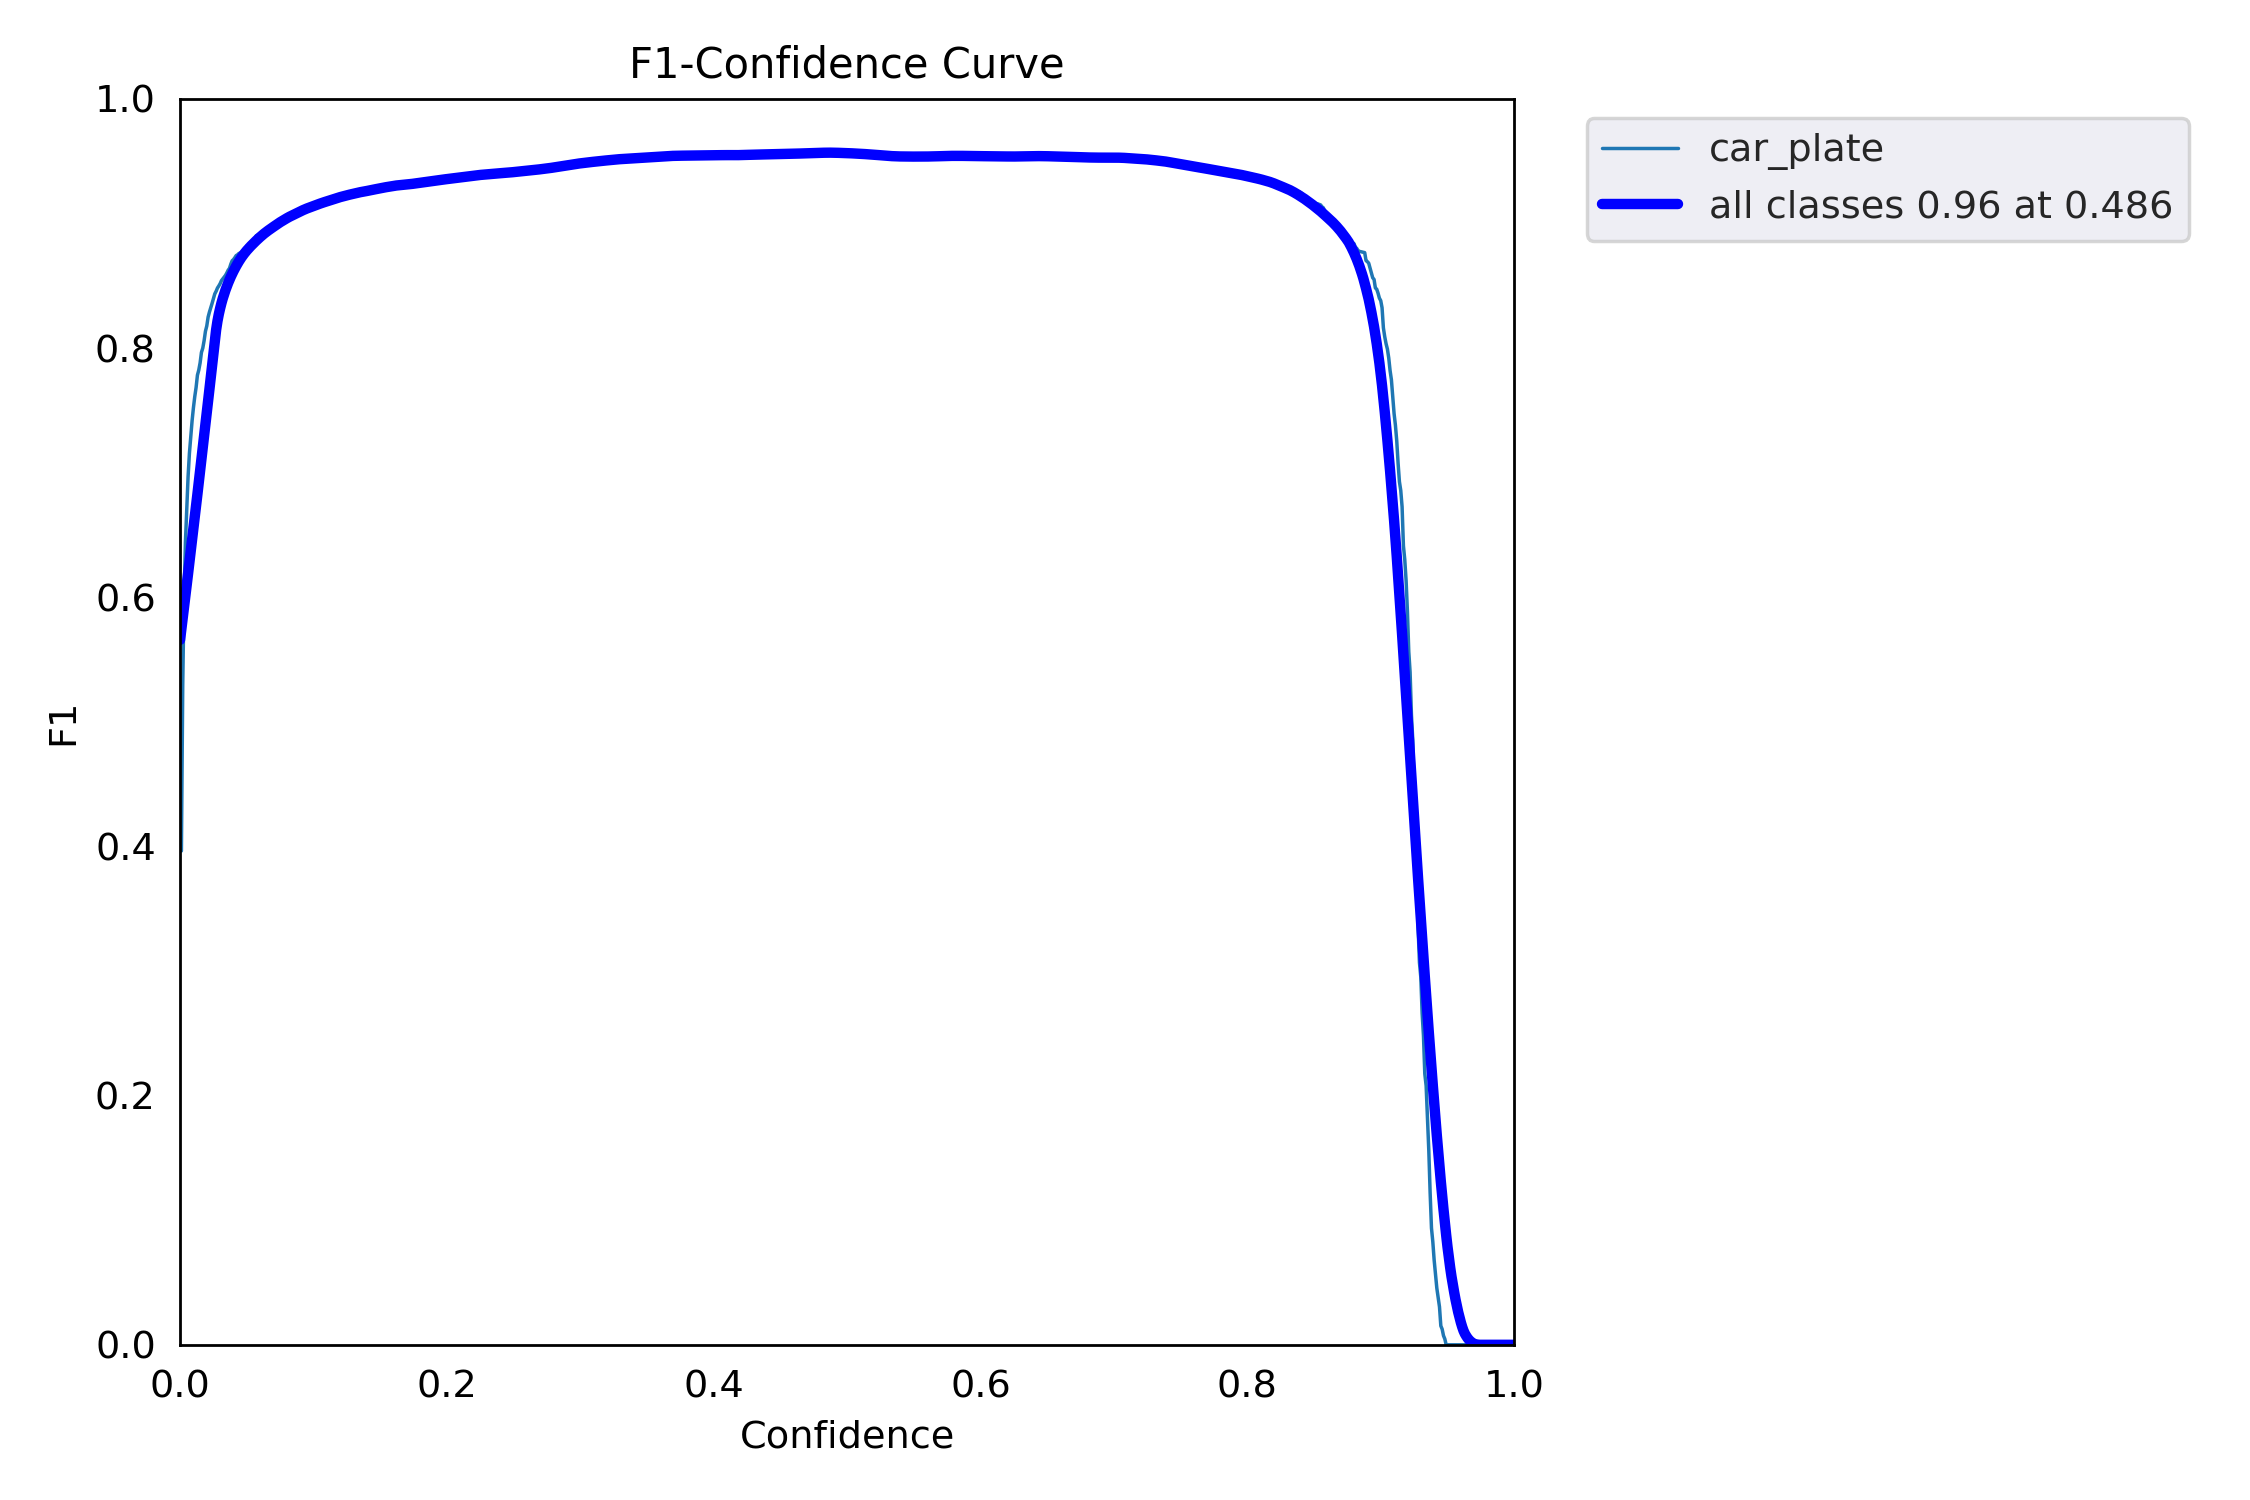

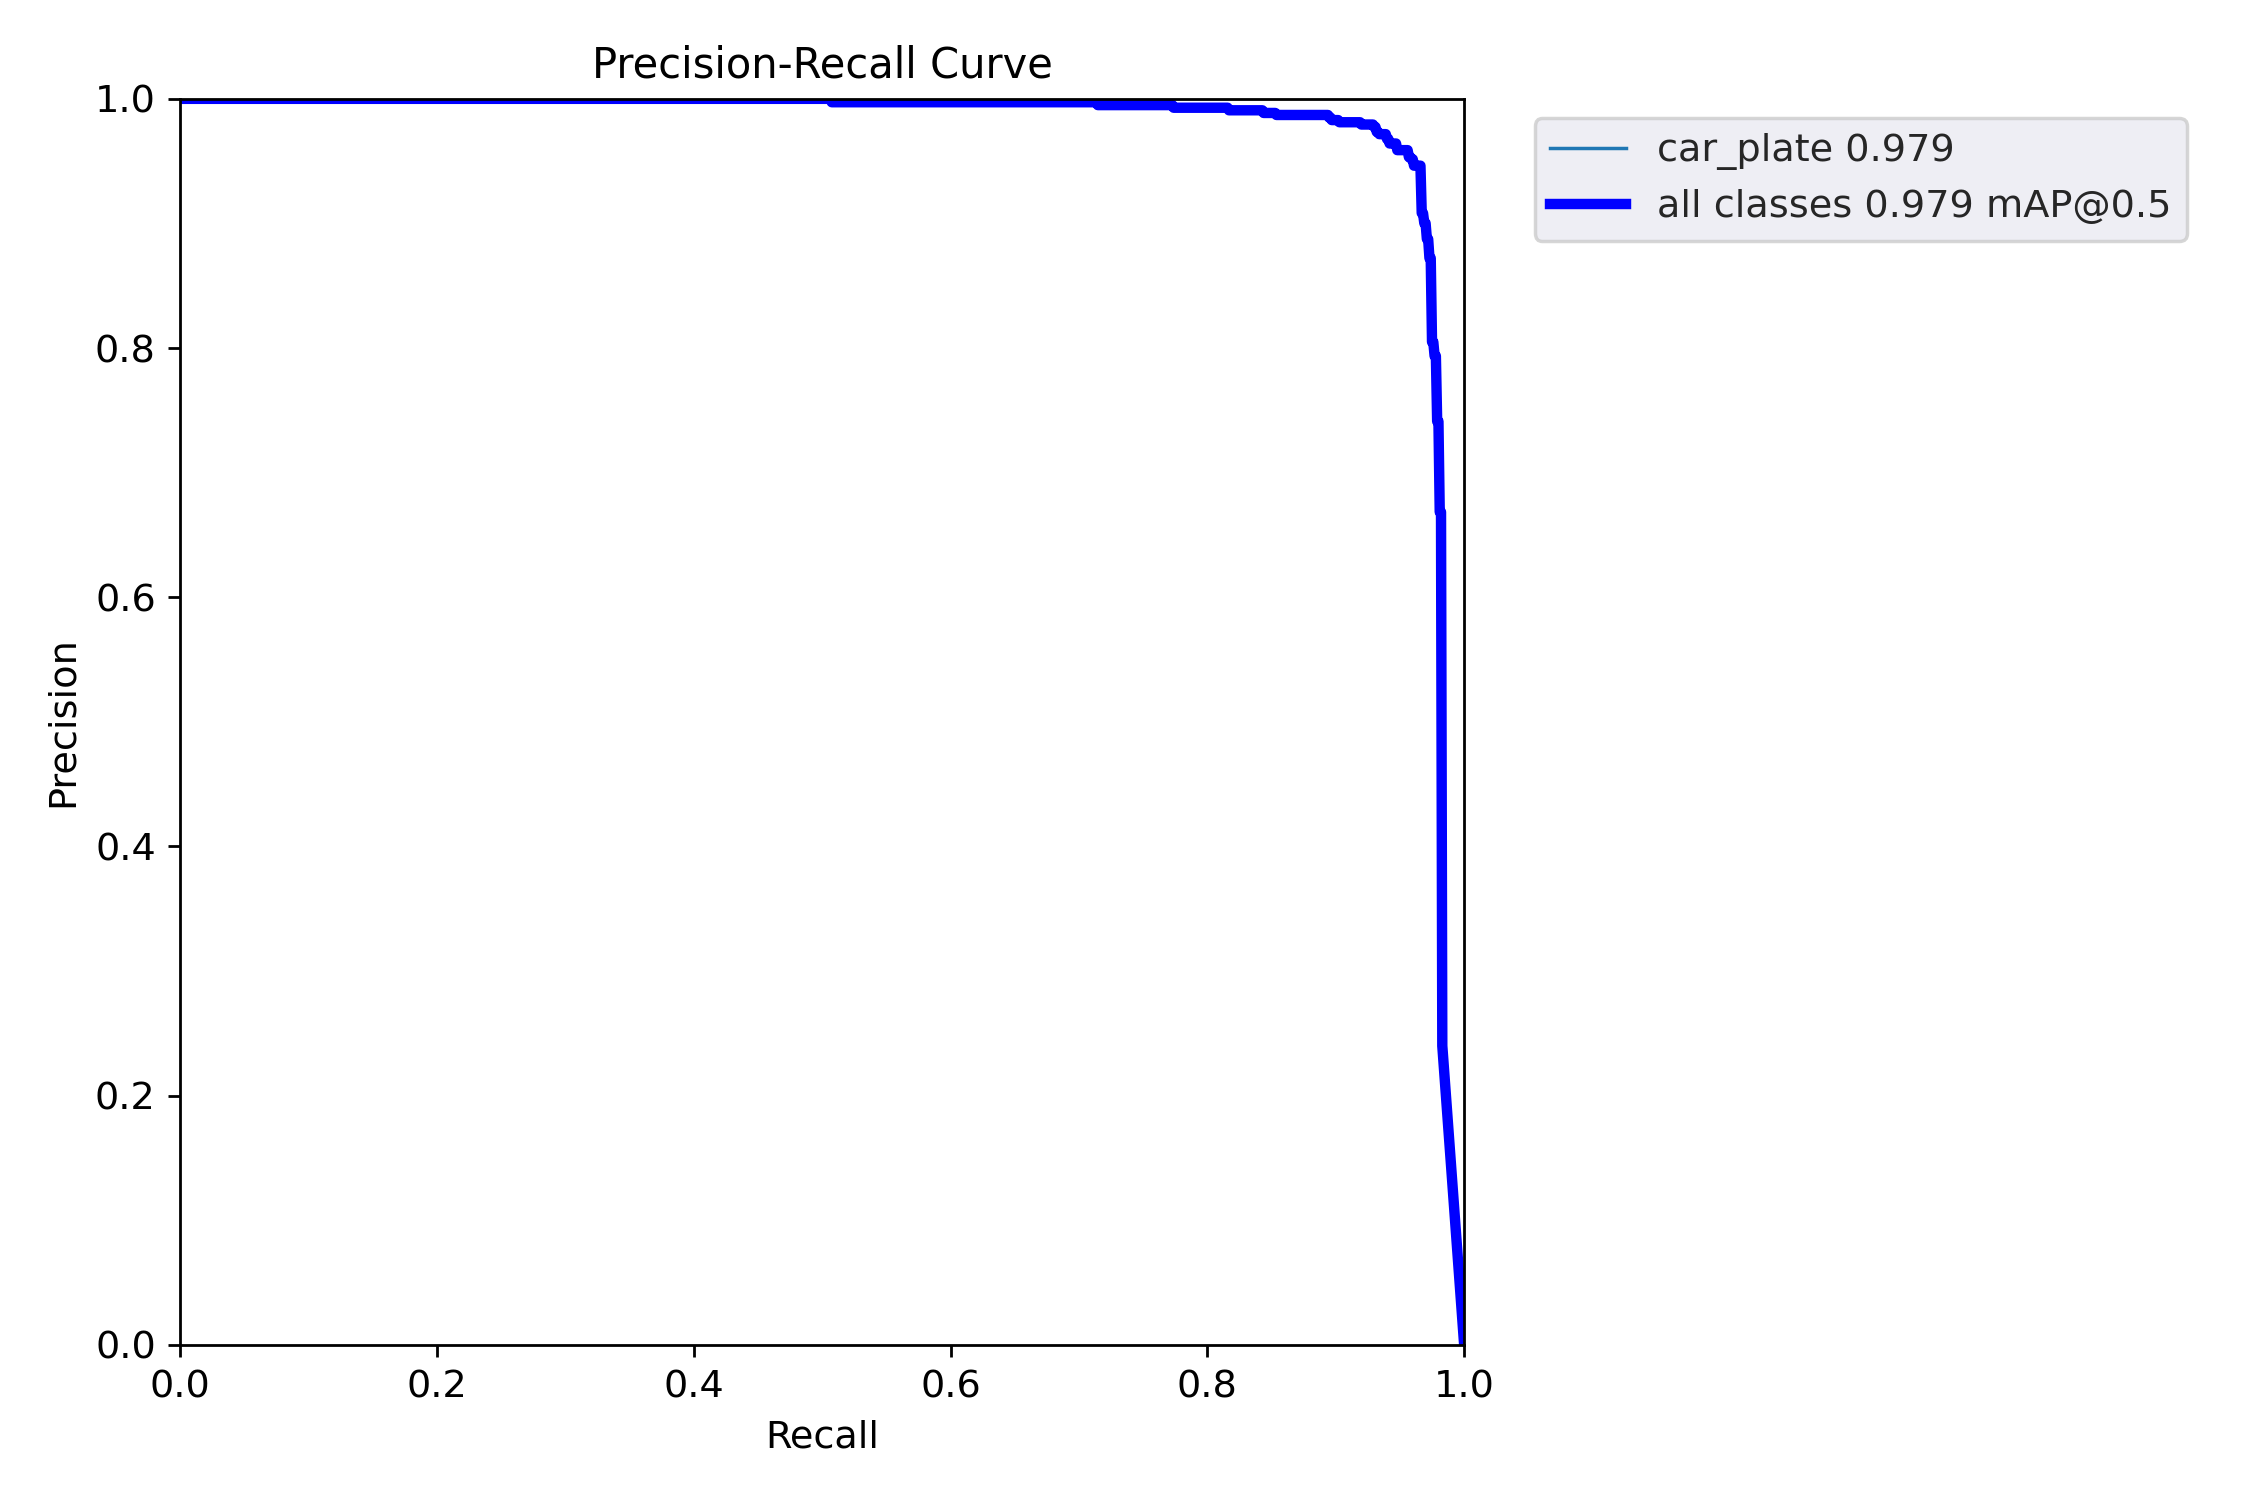

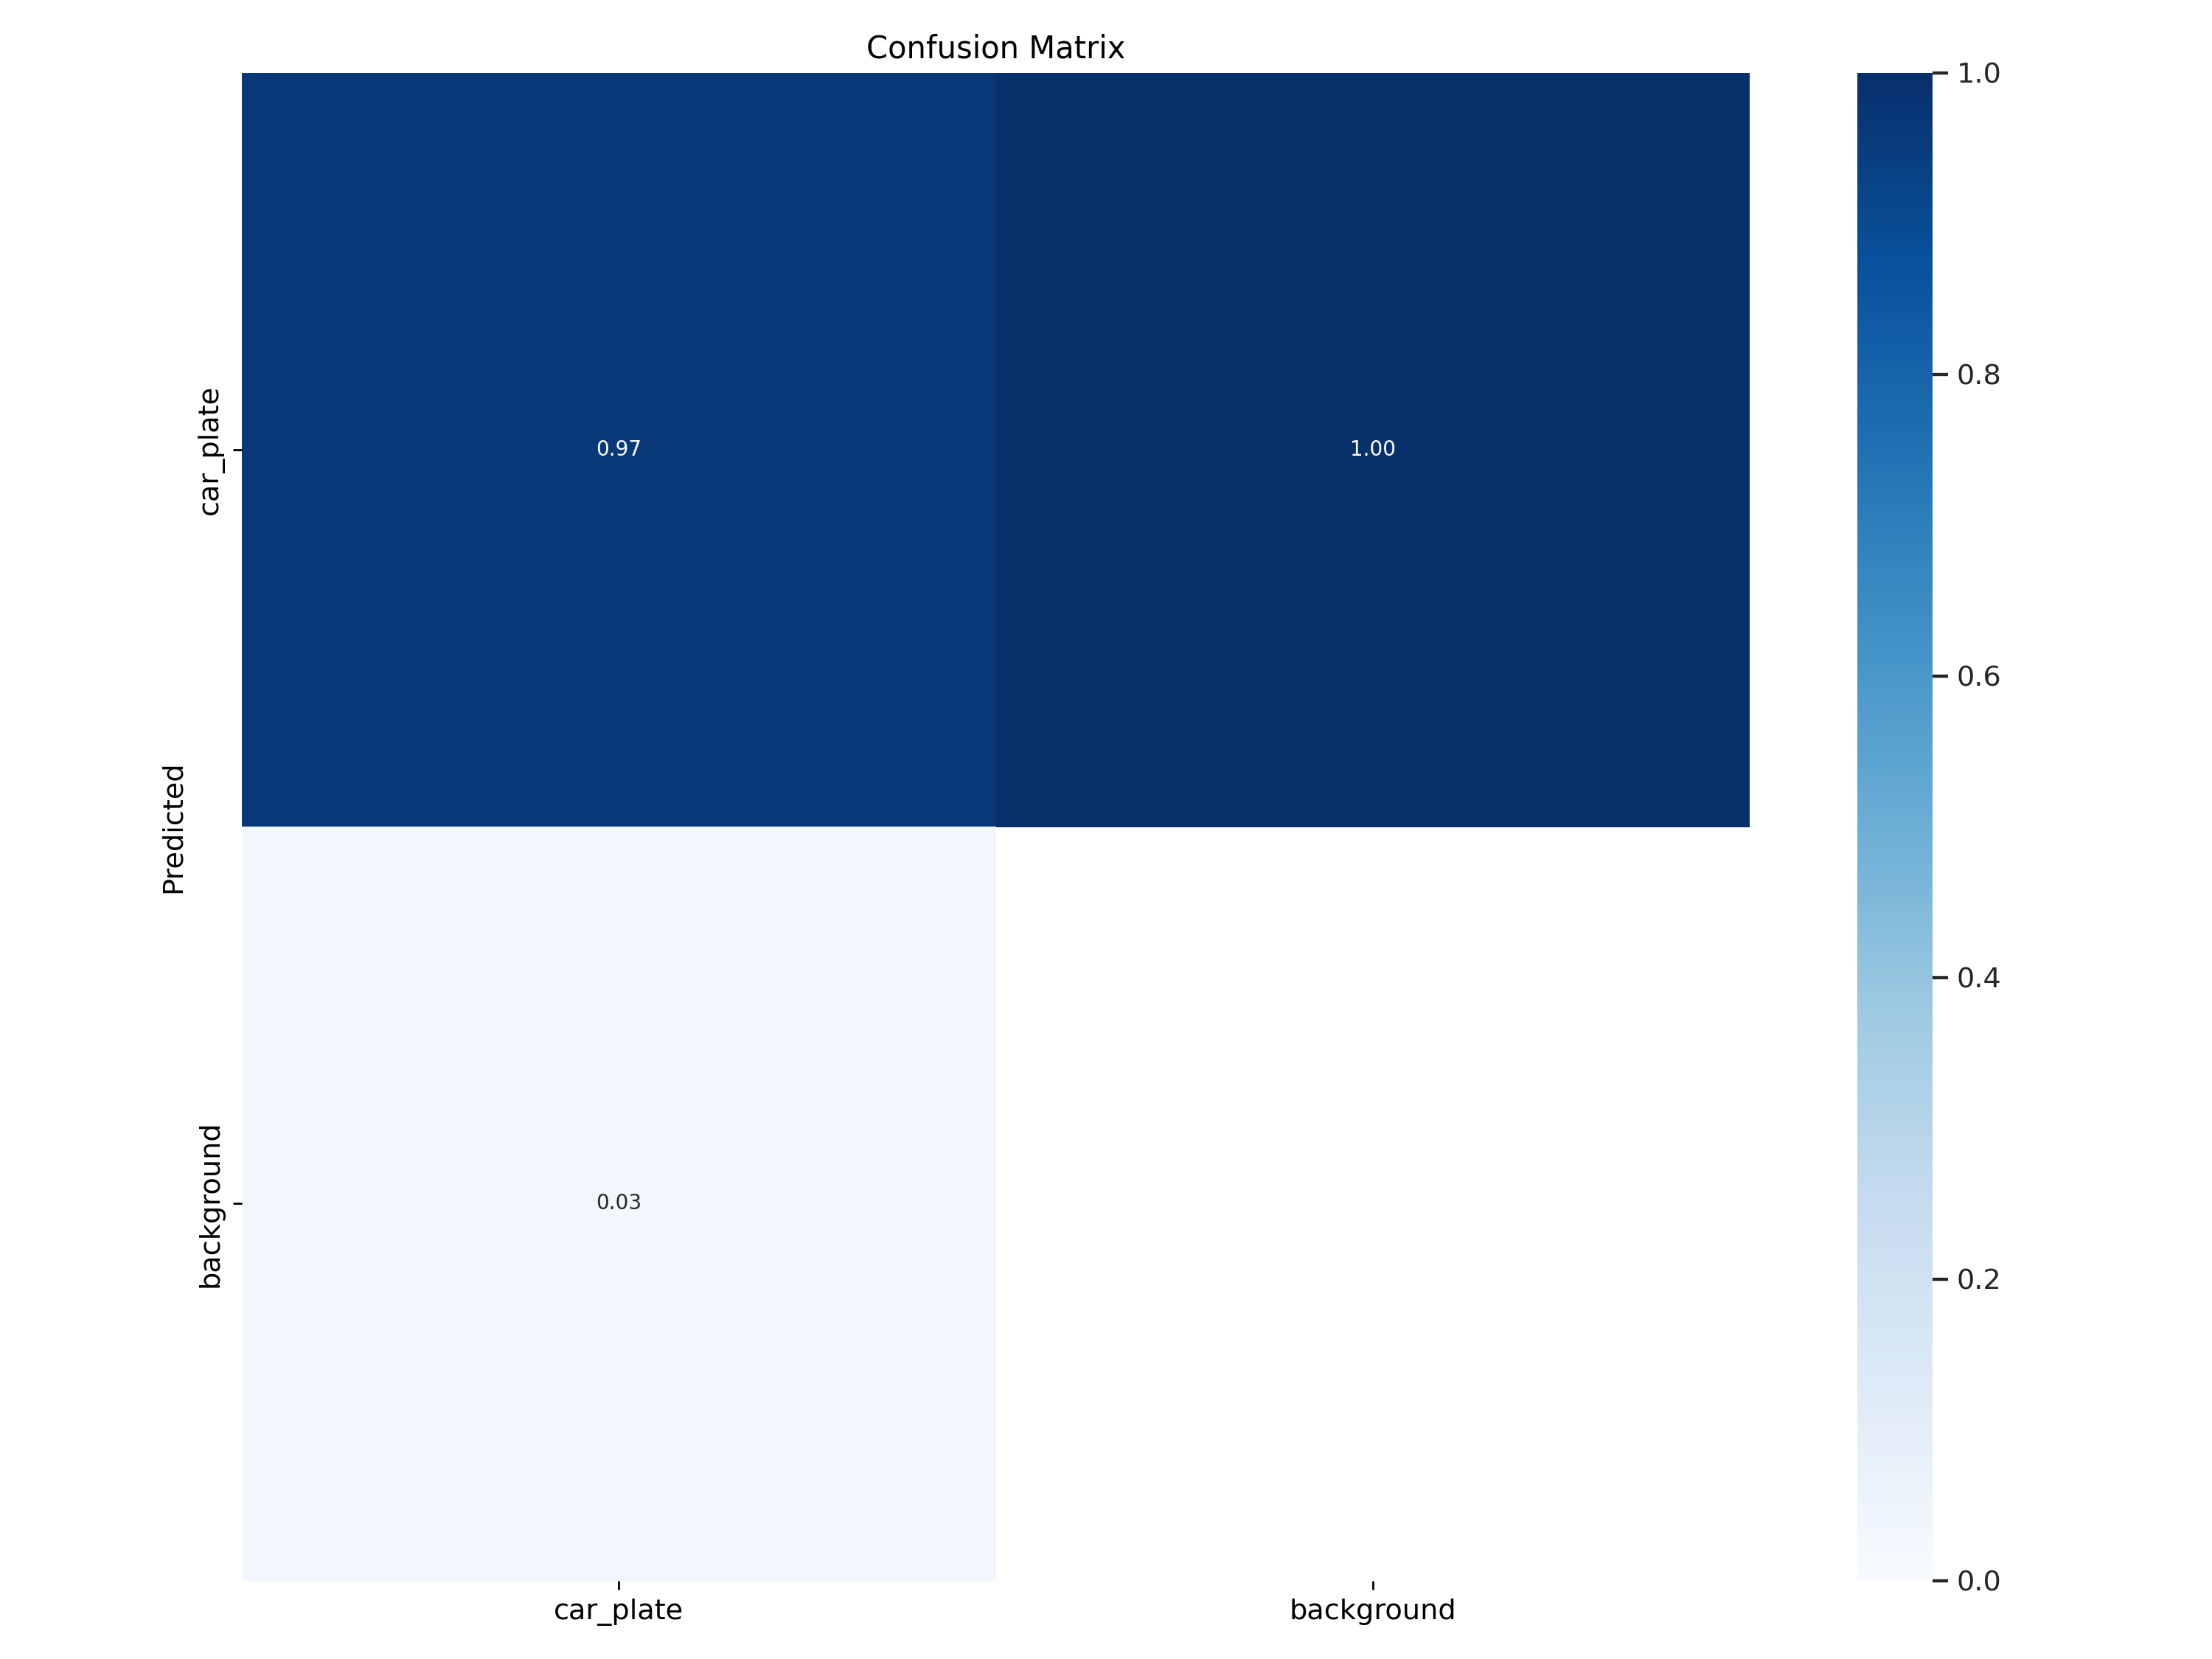

In [ ]:
display(Image("/content/data/yolov5/runs/train/Model_5L2SSS/F1_curve.png", width=400, height=400))
display(Image("/content/data/yolov5/runs/train/Model_5L2SSS/PR_curve.png", width=400, height=400))
display(Image("/content/data/yolov5/runs/train/Model_5L2SSS/confusion_matrix.png", width=500, height=500))

LABELS


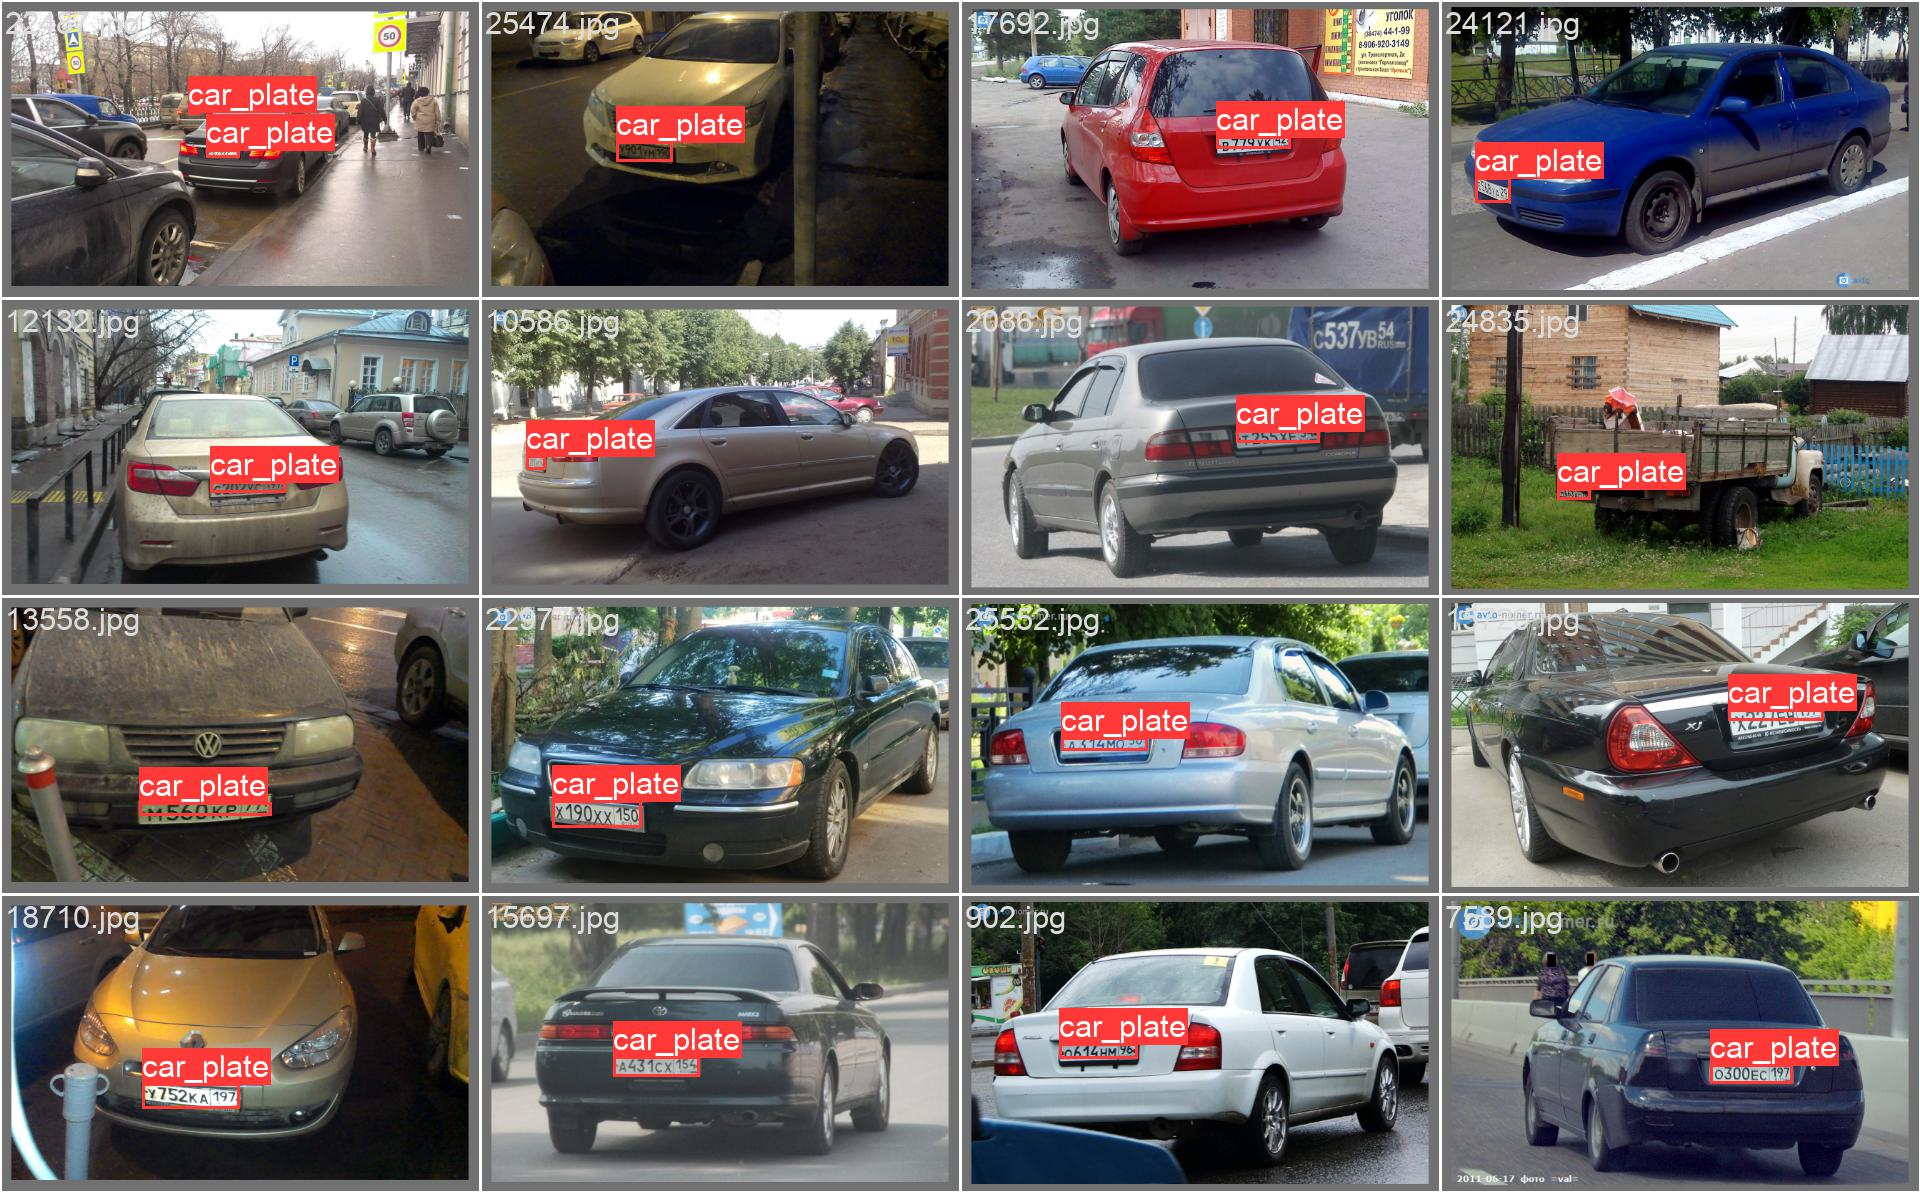

PREDICTION


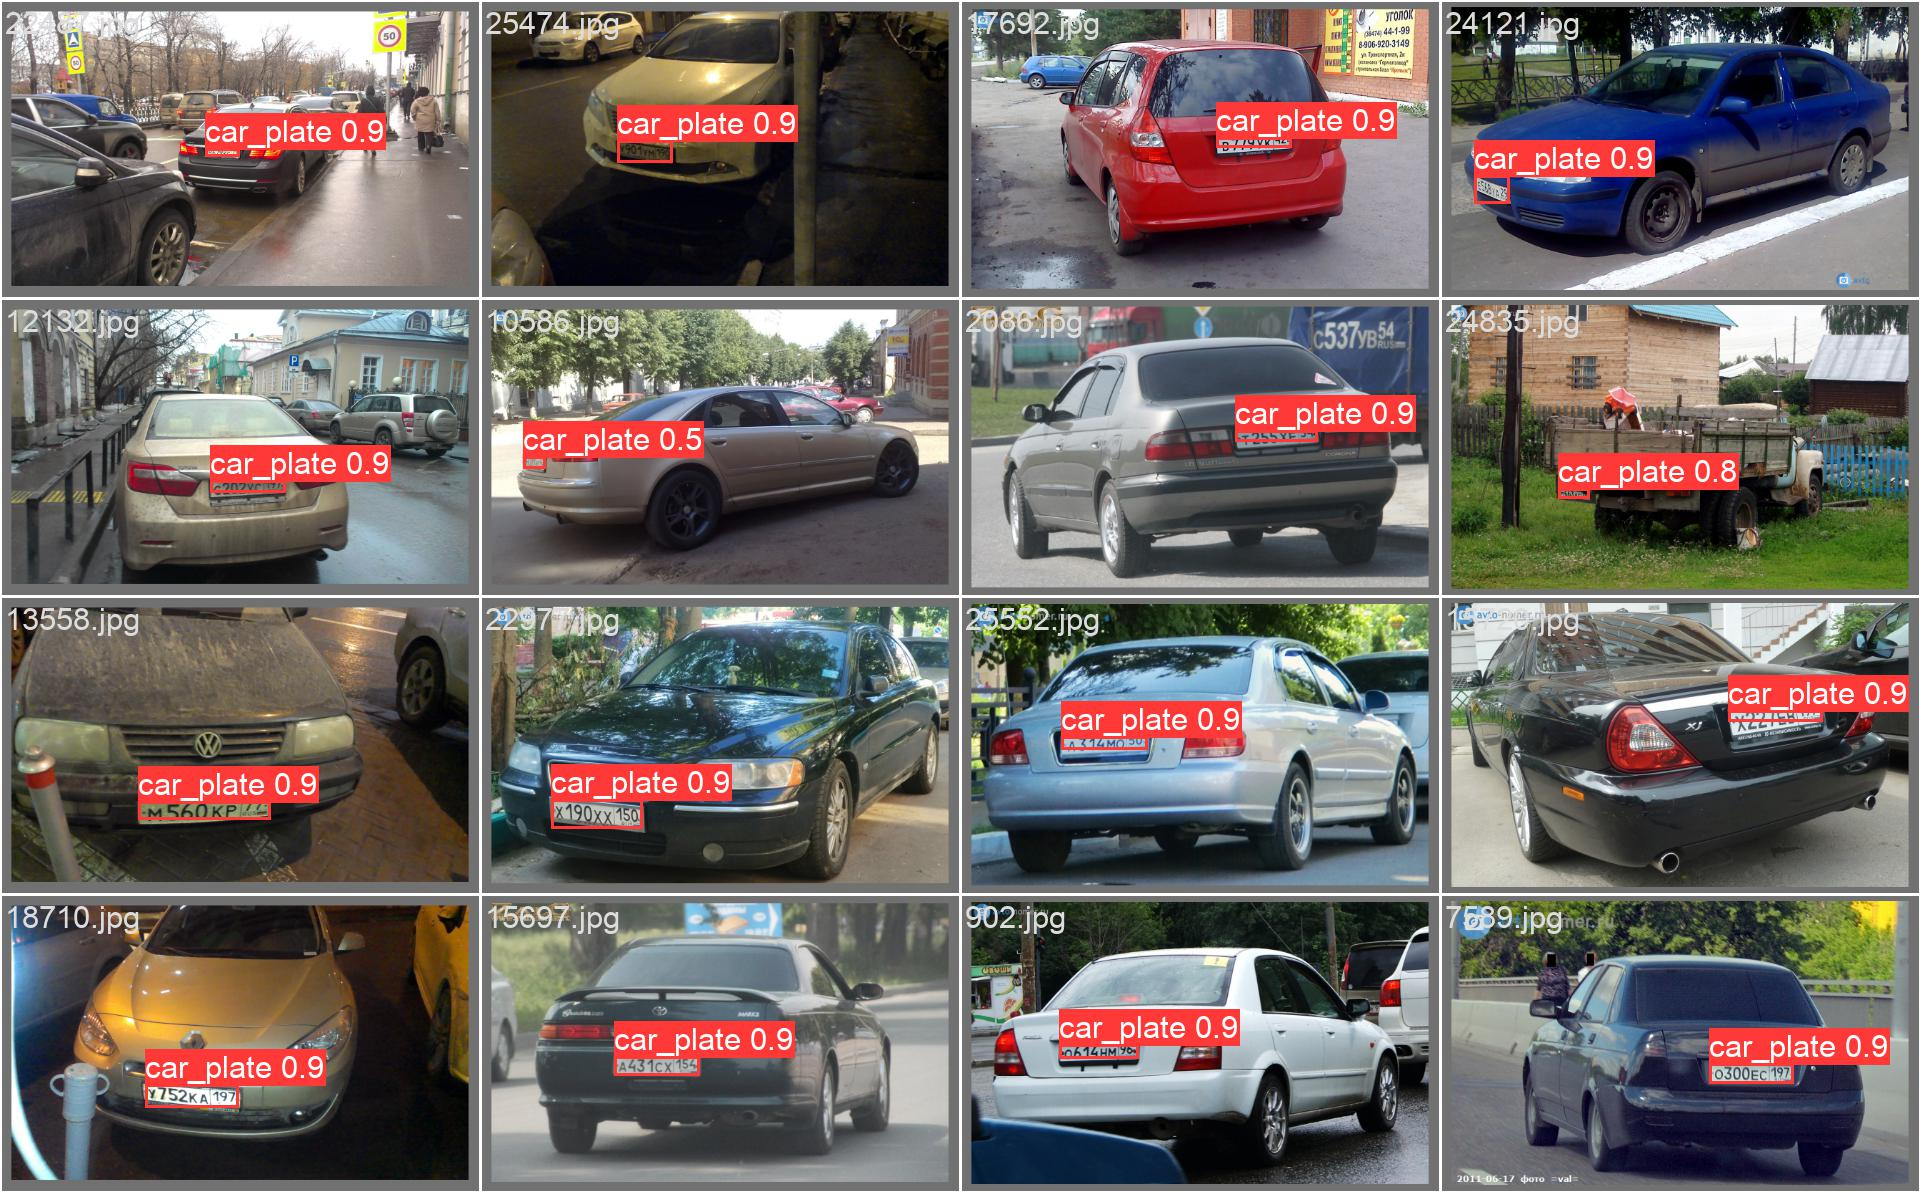

In [ ]:
# –ø–æ—Å–º–æ—Ç—Ä–∏–º —Ä–µ–∞–ª—å–Ω—É—é —Ä–∞–∑–º–µ—Ç–∫—É –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏
print('LABELS')
display(Image("/content/data/yolov5/runs/train/Model_5L2SSS/val_batch2_labels.jpg", width=800, height=800))
print('PREDICTION')
display(Image("/content/data/yolov5/runs/train/Model_5L2SSS/val_batch2_pred.jpg", width=800, height=800))

## Export to ONNX –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–π —Ä–∞–±–æ—Ç—ã —Å open cv

In [ ]:
!python export.py --weights runs/train/Model_5L2/weights/best.pt --include onnx --simplify

export: data=data/coco128.yaml, weights=['runs/train/Model_5L2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 üöÄ v6.2-182-g1158a50 Python-3.7.14 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5l summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs

PyTorch: starting from runs/train/Model_5L2/weights/best.pt with output shape (1, 25200, 6) (88.6 MB)
requirements: YOLOv5 requirement "onnx" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['onnx']
requirements: ‚ö†Ô∏è Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.12.0...
requirements